## Sanity Checks

This is a little notebook with some sanity checks.
Proper tests are in [tests/](./tests/).
This notebook is just to visually look at how the simulation behaves.

In [1]:
from itertools import product, combinations
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch
from plotnine import *
import magicsoup as ms
from magicsoup.constants import GAS_CONSTANT
from magicsoup.examples.wood_ljungdahl import CHEMISTRY, MOLECULES, REACTIONS

theme_set(theme_minimal())

### Genomes

Here, I want to check that translation and transcription of random genomes makes sense.
I would expect overall more coding regions (CDSs) and thus more proteins in larger genomes.
However, the likelihood of encountering a stop codon (in-frame) should stay the same.
So, the average CDS length and thus the expected number of domains per protein should not grow with larger genomes.

It seems to me that together with 3 start codons, 2 stop codons could be better than 3 stop codons for efficient evolution.
Coding nucleotides per nucleotide is slightly less than 1 and there are a bit more proteins with 2 domains than with one.

In [2]:
def proteome_stats(proteome: list[list], records: list[dict], size: int, record: dict):
    records.append({
        **record,
        "n": len(proteome),
        "v": "proteins/genome"
    })
    if len(proteome) > 0:
        n_doms = sum(len(d) for d in proteome)
        records.append({
            **record,
            "n": n_doms / len(proteome),
            "v": "domains/protein"
        })
        records.append({
            **record,
            "n": n_doms * genetics.dom_size / size,
            "v": "coding nts/nt"
        })

genetics = ms.Genetics()

records = []
for size in (200, 500, 1000, 2000):
    genomes = [ms.random_genome(s=size) for _ in range(1000)]
    proteomes = genetics.translate_genomes(genomes=genomes)
    for proteins in proteomes:
        proteome_stats(proteome=proteins, records=records, size=size, record={"size": size})

df = pd.DataFrame.from_records(records)

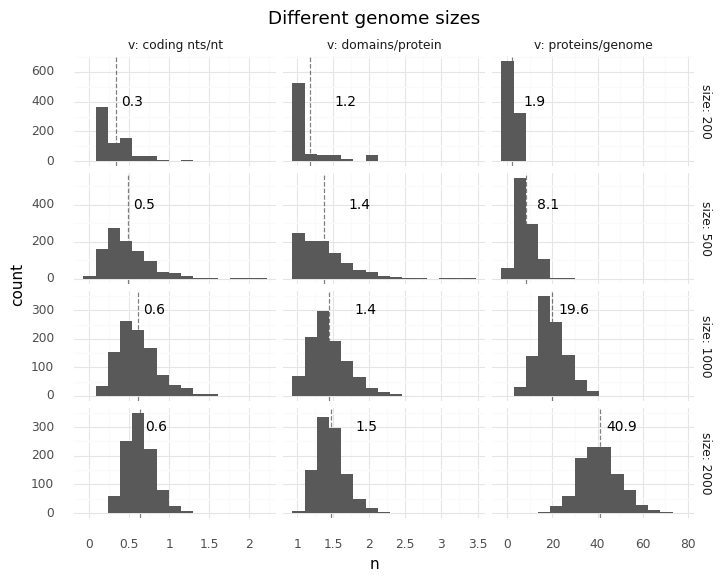

<ggplot: (8739926433717)>

In [3]:
avgs = df.groupby(["size", "v"])["n"].mean().reset_index()
avgs["l"] = [f"{d:.1f}" for d in avgs["n"]]
avgs.loc[avgs["v"] == "coding nts/nt", "x"] = avgs["n"] + 0.2
avgs.loc[avgs["v"] == "domains/protein", "x"] = avgs["n"] + 0.5
avgs.loc[avgs["v"] == "proteins/genome", "x"] = avgs["n"] + 10
avgs.loc[avgs["size"] == 200, "y"] = 400
avgs.loc[avgs["size"] == 500, "y"] = 400
avgs.loc[avgs["size"] == 1000, "y"] = 300
avgs.loc[avgs["size"] == 2000, "y"] = 300

(ggplot(df)
    + geom_vline(aes(xintercept="n"), data=avgs, linetype="dashed", alpha=0.5)
    + geom_histogram(aes(x="n"), bins=15)
    + geom_text(aes(x="x", y="y", label="l"), data=avgs, size=10)
    + facet_grid("size ~ v", scales="free", labeller="label_both")
    + theme(figure_size=(8, 6))
    + ggtitle("Different genome sizes"))

In [4]:
size = 1000
genomes = [ms.random_genome(s=size) for _ in range(1000)]

records = []
for prob in (0.001, 0.01, 0.1):
    genetics = ms.Genetics(p_reg_dom=prob, p_catal_dom=prob, p_transp_dom=prob)
    proteomes = genetics.translate_genomes(genomes=genomes)
    for proteins in proteomes:
        proteome_stats(proteome=proteins, records=records, size=size, record={"prob": prob})

df = pd.DataFrame.from_records(records)

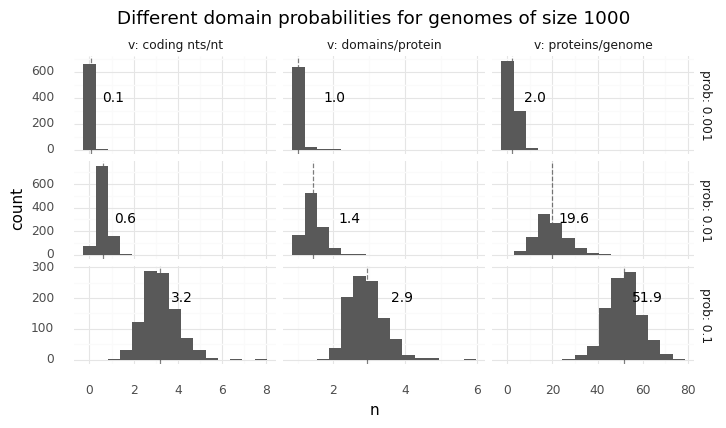

<ggplot: (8740174589550)>

In [5]:
avgs = df.groupby(["prob", "v"])["n"].mean().reset_index()
avgs["l"] = [f"{d:.1f}" for d in avgs["n"]]
avgs.loc[avgs["v"] == "coding nts/nt", "x"] = avgs["n"] + 1
avgs.loc[avgs["v"] == "domains/protein", "x"] = avgs["n"] + 1
avgs.loc[avgs["v"] == "proteins/genome", "x"] = avgs["n"] + 10
avgs.loc[avgs["prob"] == 0.001, "y"] = 400
avgs.loc[avgs["prob"] == 0.01, "y"] = 300
avgs.loc[avgs["prob"] == 0.1, "y"] = 200

(ggplot(df)
    + geom_vline(aes(xintercept="n"), data=avgs, linetype="dashed", alpha=0.5)
    + geom_histogram(aes(x="n"), bins=15)
    + geom_text(aes(x="x", y="y", label="l"), data=avgs, size=10)
    + facet_grid("prob ~ v", scales="free", labeller="label_both")
    + theme(figure_size=(8, 4))
    + ggtitle(f"Different domain probabilities for genomes of size {size}"))

In [6]:
kwargs_map = {
    "3-3": {},
    "2-3": {"start_codons": ("ATG", "GTG")},
    "1-3": {"start_codons": ("ATG", )},
    "3-2": {"stop_codons": ("TAG", "TAA")},
    "3-1": {"stop_codons": ("TAG", )}
}
genomes = [ms.random_genome(s=size) for _ in range(1000)]

records = []
for label, kwargs in kwargs_map.items():
    genetics = ms.Genetics(**kwargs)
    proteomes = genetics.translate_genomes(genomes=genomes)
    for proteins in proteomes:
        proteome_stats(proteome=proteins, records=records, size=size, record={"start-stop": label})

df = pd.DataFrame.from_records(records)

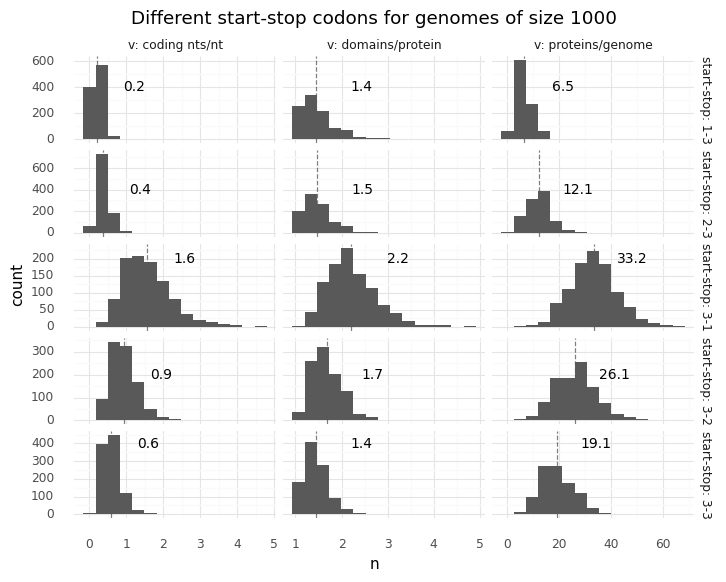

<ggplot: (8740130881476)>

In [7]:
avgs = df.groupby(["start-stop", "v"])["n"].mean().reset_index()
avgs["l"] = [f"{d:.1f}" for d in avgs["n"]]
avgs.loc[avgs["v"] == "coding nts/nt", "x"] = avgs["n"] + 1
avgs.loc[avgs["v"] == "domains/protein", "x"] = avgs["n"] + 1
avgs.loc[avgs["v"] == "proteins/genome", "x"] = avgs["n"] + 15
avgs.loc[avgs["start-stop"] == "1-3", "y"] = 400
avgs.loc[avgs["start-stop"] == "2-3", "y"] = 400
avgs.loc[avgs["start-stop"] == "3-1", "y"] = 200
avgs.loc[avgs["start-stop"] == "3-2", "y"] = 200
avgs.loc[avgs["start-stop"] == "3-3", "y"] = 400

(ggplot(df)
    + geom_vline(aes(xintercept="n"), data=avgs, linetype="dashed", alpha=0.5)
    + geom_histogram(aes(x="n"), bins=15)
    + geom_text(aes(x="x", y="y", label="l"), data=avgs, size=10)
    + facet_grid("start-stop ~ v", scales="free", labeller="label_both")
    + theme(figure_size=(8, 6))
    + ggtitle(f"Different start-stop codons for genomes of size {size}"))

### Molecule Diffusion and Degradation

Below, I just want to see on a small map whether diffusion and degradation looks correct (_e.g._ using the circular map).
The diffusion coefficients and half lifes are what I would expect to be realistic values.
It would also be nice to see that differences in diffusion with different diffusion coefficients, and differences in degradation with different half lifes
actually make a visible difference.

Realisticly a map would be several hundred pixels wide and things would diffuse and degrade within hundreds of steps.
But that's difficult to visualize in detail, so I just scale down everything to a short half life and small map.

In [17]:
ms.Molecule._instances = {}  # rm previous instances
molecules = [
    ms.Molecule("fast-stable", 10, diffusivity=1.0, half_life=1_000),
    ms.Molecule("fast-medium", 10, diffusivity=1.0, half_life=100),
    ms.Molecule("fast-unstable", 10, diffusivity=1.0, half_life=10),
    ms.Molecule("medium-stable", 10, diffusivity=0.1, half_life=1_000),
    ms.Molecule("medium-medium", 10, diffusivity=0.1, half_life=100),
    ms.Molecule("medium-unstable", 10, diffusivity=0.1, half_life=10),
    ms.Molecule("slow-stable", 10, diffusivity=0.01, half_life=1_000),
    ms.Molecule("slow-medium", 10, diffusivity=0.01, half_life=100),
    ms.Molecule("slow-unstable", 10, diffusivity=0.01, half_life=10)
]

chemistry = ms.Chemistry(molecules=molecules, reactions=[])
world = ms.World(chemistry=chemistry, map_size=32, mol_map_init="zeros")
world.molecule_map[:, :5, :5] = 10.0
world.molecule_map[:, 10:-10, 10] = 10.0
world.molecule_map[:, 10:-10, 20] = 10.0
world.molecule_map[:, 19, 12:18] = 10.0
world.molecule_map[:, 12, 12:18] = 10.0

records = []
for si in range(10):
    for mi, mol in enumerate(molecules):
        record = {"step": si, "mol": mol.name}
        for x, y in product(range(world.map_size), range(world.map_size)):
            records.append({
                **record,
                "x": x,
                "y": y,
                "[x]": world.molecule_map[mi, x, y].item()
            })
    world.diffuse_molecules()
    world.degrade_molecules()
df = pd.DataFrame.from_records(records)
df["mol"] = pd.Categorical(df["mol"], categories=[d.name for d in molecules], ordered=True)

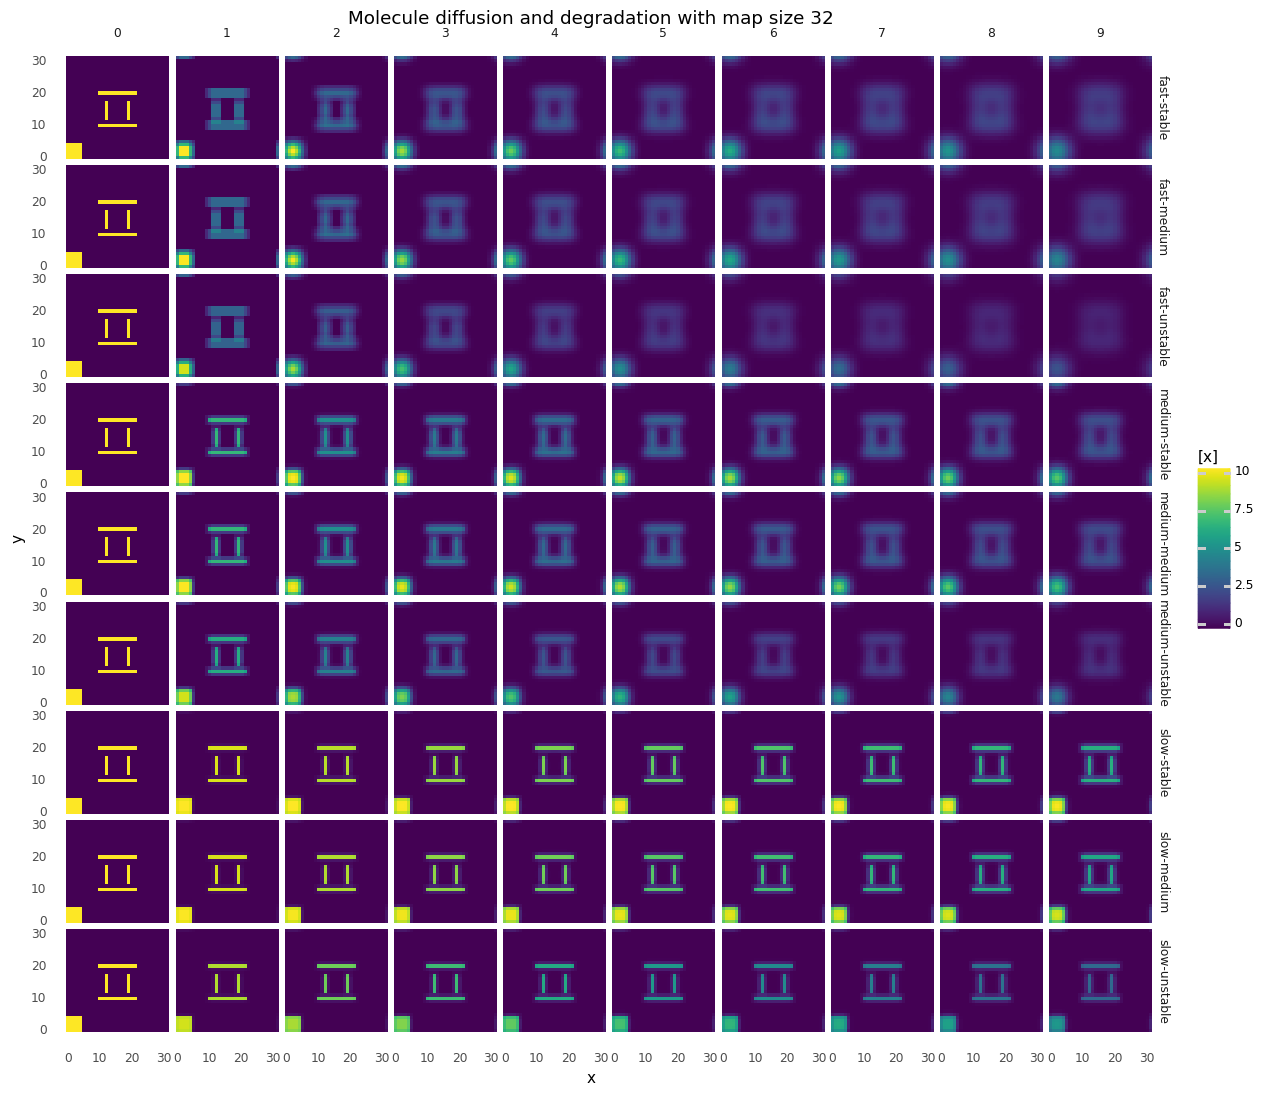

<ggplot: (8735498757244)>

In [18]:
(ggplot(df)
    + geom_raster(aes(x="x", y="y", fill="[x]"))
    + facet_grid("mol ~ step")
    + coord_equal(expand=False)
    + theme(figure_size=(14, 6))
    + ggtitle(f"Molecule diffusion and degradation with map size {world.map_size}"))

In [19]:
mol_i = 0
dffy = chemistry.molecules[mol_i].diffusivity

def gradient1d(world: ms.World):
    world.molecule_map[mol_i, [63, 64]] = 100.0
    world.molecule_map[mol_i, [0, -1]] = 1.0

def gradient2d(world: ms.World):
    xs = [32, 64, 96, 32, 64, 96, 32, 64, 96]
    ys = [32, 32, 32, 64, 64, 64, 96, 96, 96]
    world.molecule_map[mol_i, xs, ys] = 100.0
    world.molecule_map[mol_i, [0, 127]] = 1.0
    world.molecule_map[mol_i, :, [0, 127]] = 1.0

gradient_map = {
    "1D": gradient1d,
    "2D": gradient2d,
}

records = []
for label, fun in gradient_map.items():
    world = ms.World(chemistry=chemistry, mol_map_init="zeros")
    for si in range(601):
        fun(world=world)
        if si % 100 == 0:
            record = {"step": si, "grad": label}
            for x, y in product(range(128), range(128)):
                records.append({
                    **record,
                    "x": x,
                    "y": y,
                    "[x]": world.molecule_map[mol_i, x, y].item()
                })
        world.diffuse_molecules()
        world.degrade_molecules()

df = pd.DataFrame.from_records(records)

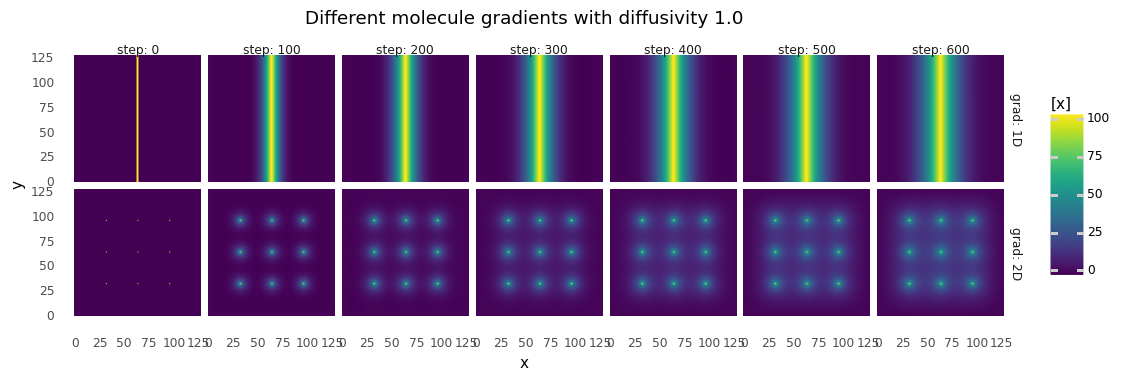

<ggplot: (8735516157956)>

In [20]:
(ggplot(df)
    + geom_raster(aes(x="x", y="y", fill="[x]"))
    + facet_grid("grad ~ step", labeller="label_both")
    + coord_equal(expand=False)
    + theme(figure_size=(12, 6))
    + ggtitle(f"Different molecule gradients with diffusivity {dffy}"))

## Equilibrium Constants

All reactions are reversible and happen in both directions at the same time.
The ratios of their forward and backward rates define an equilibrium where forward and backward rates are the same.
At this equilibrium state the reaction quotient is $Q = K_e$.
In this simulation the target $K_e$ is derived from $\Delta G_0 = RT \ln K_e$.
$\Delta G_0$ is calculated from the energies of molecules involved in the reaction.

There are tests checking that these calculations are correct.
Here, I want to look at what kind of $K_e$ values are common.
Theoretically all reactions are reversible.
But if a $|\log(K_e)|$ is extremely high (or low) it becomes basically impossible for the reverse reaction to occur.
Typical molecule concentrations would range between 1e-7 and 100.
At very low values calculations become unreliable and can jump to 0.0.
So the reaction quotient would never get large (or small) enough to drive the reverse reaction.
For the sake of interpretability, a 100-fold change would be around $\exp(4.6)$.

/home/marc/anaconda3/envs/magicsoup_dev/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_jitter : Removed 21 rows containing missing values.


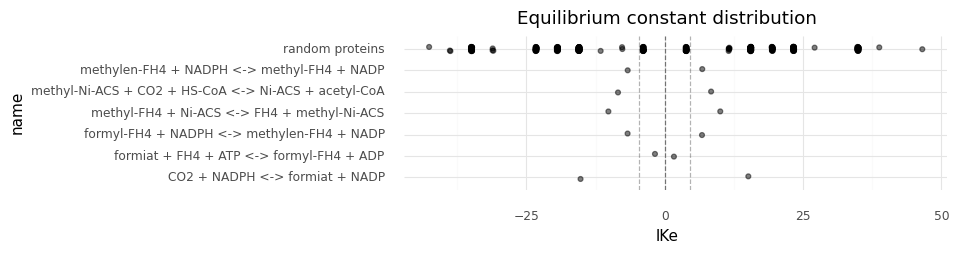

<ggplot: (8740131591184)>

In [12]:
world = ms.World(chemistry=CHEMISTRY)

records = []
for subs, prods in REACTIONS:
    name = " + ".join(str(d) for d in subs) + " <-> " + " + ".join(str(d) for d in prods)
    energy = sum(d.energy for d in prods) - sum(d.energy for d in subs)
    lke = -energy / GAS_CONSTANT / world.abs_temp / 2.303
    records.append({"name": name, "lKe": lke})
    records.append({"name": name, "lKe": -lke})

genomes = [ms.random_genome(s=500) for _ in range(100)]
world.spawn_cells(genomes=genomes)
lKe = torch.log(world.kinetics.Kmb / world.kinetics.Kmf)
for lke in lKe[lKe != 0.0].flatten().tolist():
    records.append({"name": "random proteins", "lKe": lke})

df = pd.DataFrame.from_records(records)

(ggplot(df, aes(x="name", y="lKe"))
    + geom_hline(yintercept=0.0, linetype="dashed", alpha=.5)
    + geom_hline(yintercept=[-4.6, 4.6], linetype="dashed", alpha=.3)
    + geom_jitter(data=df, alpha=.5, width=.1, height=.1)
    + coord_flip()
    + theme(figure_size=(7, 2))
    + ggtitle("Equilibrium constant distribution"))

/home/marc/anaconda3/envs/magicsoup_dev/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_ydensity : Removed 831 rows containing non-finite values.


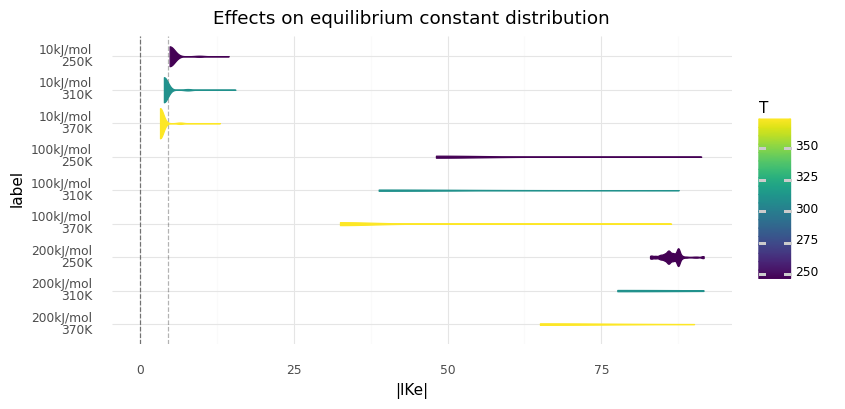

<ggplot: (8739905709252)>

In [13]:
abs_temps = [250, 310, 370]
energies = [10, 100, 200]
n_mols = 10

records = []
for energy in energies:
    for abs_temp in abs_temps:
        ms.Molecule._instances = {}  # rm previous instances
        molecules = [ms.Molecule(str(i), energy * 1e3) for i in range(n_mols)]
        reactions = [([a, b], [c]) for a, b, c in combinations(molecules, 3)]
        chemistry = ms.Chemistry(molecules=molecules, reactions=reactions)
        world = ms.World(chemistry=chemistry, abs_temp=abs_temp)
        genomes = [ms.random_genome(s=500) for _ in range(1000)]
        world.spawn_cells(genomes=genomes)
        lKe = torch.log(world.kinetics.Kmb / world.kinetics.Kmf).abs()
        label = f"{energy}kJ/mol\n{abs_temp}K"
        for lke in lKe[lKe != 0.0].flatten().tolist():
            records.append({"label": label, "|lKe|": lke, "T": abs_temp})

df = pd.DataFrame.from_records(records)
df["label"] = pd.Categorical(df["label"], categories=reversed(df["label"].unique()))

(ggplot(df)
    + geom_hline(yintercept=0, linetype="dashed", alpha=.5)
    + geom_hline(yintercept=4.6, linetype="dashed", alpha=.3)
    + geom_violin(aes(x="label", y="|lKe|", color="T", fill="T"), position="dodge")
    + coord_flip()
    + theme(figure_size=(8, 4))
    + ggtitle("Effects on equilibrium constant distribution"))

With increasing catalytic efficiency $E_{cat} = V_{max} / K_M$ (here)
it becomes increasingly less likely for a reaction to reach its equilibrium state because it always largely overshoots it.
One can increase the number of computations for each step (basically reducing $V_{max}$ in each computation)
but this would make the simulation extremely slow.
It would need hundreds of computations to deal with reasonably high $E_{cat}$.
Instead a method is used in which computational steps become increasingly smaller.
This reduces the amount of computations per step considerably.

I have some tests to check that equilbriums are always reached within certain limits.
Here, I just want to see how smooth this actually happens.
Reactions with high stoichiometric numbers tend to behave more chaotic because of their sharper reaction profiles.

In [14]:
ms.Molecule._instances = {}  # rm previous instances
_ma = ms.Molecule("A", 1e3)
_mb = ms.Molecule("B", 1e3)
_mc = ms.Molecule("C", 1e3)
molecules = [_ma, _mb, _mc]
reactions = [([_ma, _mb], [_mc]), ([_ma, _ma, _ma], [_mc])]

n_steps = 50
n_cells = 36

trials = [
    (
        "transport C | 0 J",
        ms.ProteinFact(domain_facts=[ms.TransporterDomainFact(_mc)]),
        lambda i, x, y, cm, mm: cm[i][2] / mm[2][x][y],
        1.0
    ),
    (
        "A + B <-> C | -1 kJ",
        ms.ProteinFact(domain_facts=[ms.CatalyticDomainFact(([_ma, _mb], [_mc]))]),
        lambda i, x, y, cm, mm: cm[i][2] / cm[i][0] / cm[i][1],
        math.exp(1e3 / world.kinetics.abs_temp / GAS_CONSTANT)
    ),
    (
        "3 A <-> C | -2 kJ",
        ms.ProteinFact(domain_facts=[ms.CatalyticDomainFact(([_ma, _ma, _ma], [_mc]))]),
        lambda i, x, y, cm, mm: cm[i][2] / cm[i][0] / cm[i][0] / cm[i][0],
        math.exp(2e3 / world.kinetics.abs_temp / GAS_CONSTANT)
    )
]

In [15]:
def evenly_position_cells(world: ms.World, padding: int):
    x_pad = padding
    y_pad = padding
    cell_i = 0
    positions = []
    while cell_i < world.n_cells:
        if x_pad < world.map_size:
            positions.append([x_pad, y_pad])
            x_pad += padding
            cell_i += 1
        else:
            x_pad = padding
            y_pad += padding
    world.cell_positions = torch.tensor(positions).long()
    world.cell_map[:] = False
    world.cell_map[world.cell_positions[:, 0], world.cell_positions[:, 1]] = True

In [16]:
ke_records = []
records = []
for label, protein, get_q, ke in trials:
    chem = ms.Chemistry(molecules=molecules, reactions=reactions)
    world = ms.World(chemistry=chem, mol_map_init="zeros")

    ke_records.append({"Q": ke, "label": label})

    genomes = []
    while len(genomes) < n_cells:
        genome = world.generate_genome(proteome=[protein], size=30)
        proteomes = world.genetics.translate_genomes(genomes=[genome])
        if len(proteomes) == 1 and len(proteomes[0]) == 1:
            genomes.append(genome)

    world.spawn_cells(genomes=genomes)
    evenly_position_cells(world=world, padding=int(world.map_size / n_cells**0.5))
    world.molecule_map[:] = 10.0
    world.cell_molecules[:, [0, 1]] = 10.0

    for step_i in range(n_steps):
        for cell_i in range(world.n_cells):
            x, y = world.cell_positions[cell_i].tolist()
            ecat = world.kinetics.Vmax[cell_i][0] / world.kinetics.Kmf[cell_i][0]
            q = get_q(cell_i, x, y, world.cell_molecules, world.molecule_map)
            records.append({
                "label": label,
                "cell": cell_i,
                "step": step_i,
                "Ecat": ecat.item(),
                "Q": q.item(),
            })
        world.enzymatic_activity()
        world.diffuse_molecules()
df = pd.DataFrame.from_records(records)
ke_df = pd.DataFrame.from_records(ke_records)

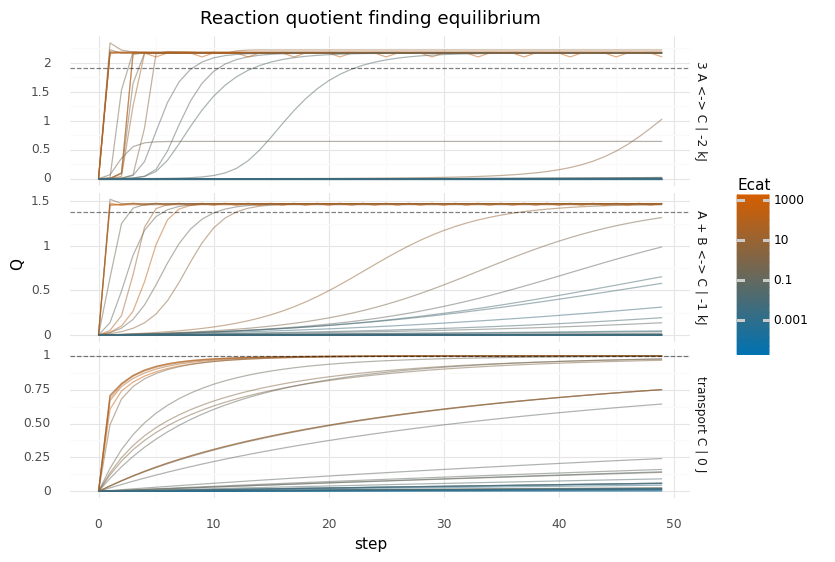

<ggplot: (8740120504831)>

In [17]:
(ggplot(df)
    + geom_line(aes(x="step", y="Q", color="Ecat", group="cell"), alpha=.5)
    + geom_hline(aes(yintercept="Q"), data=ke_df, alpha=0.5, linetype="dashed")
    + scale_color_gradient(name="Ecat", trans="log10", high="#D55E00", low="#0072B2")
    + facet_grid("label ~ .", scales="free")
    + theme(figure_size=(8, 6))
    + ggtitle("Reaction quotient finding equilibrium"))

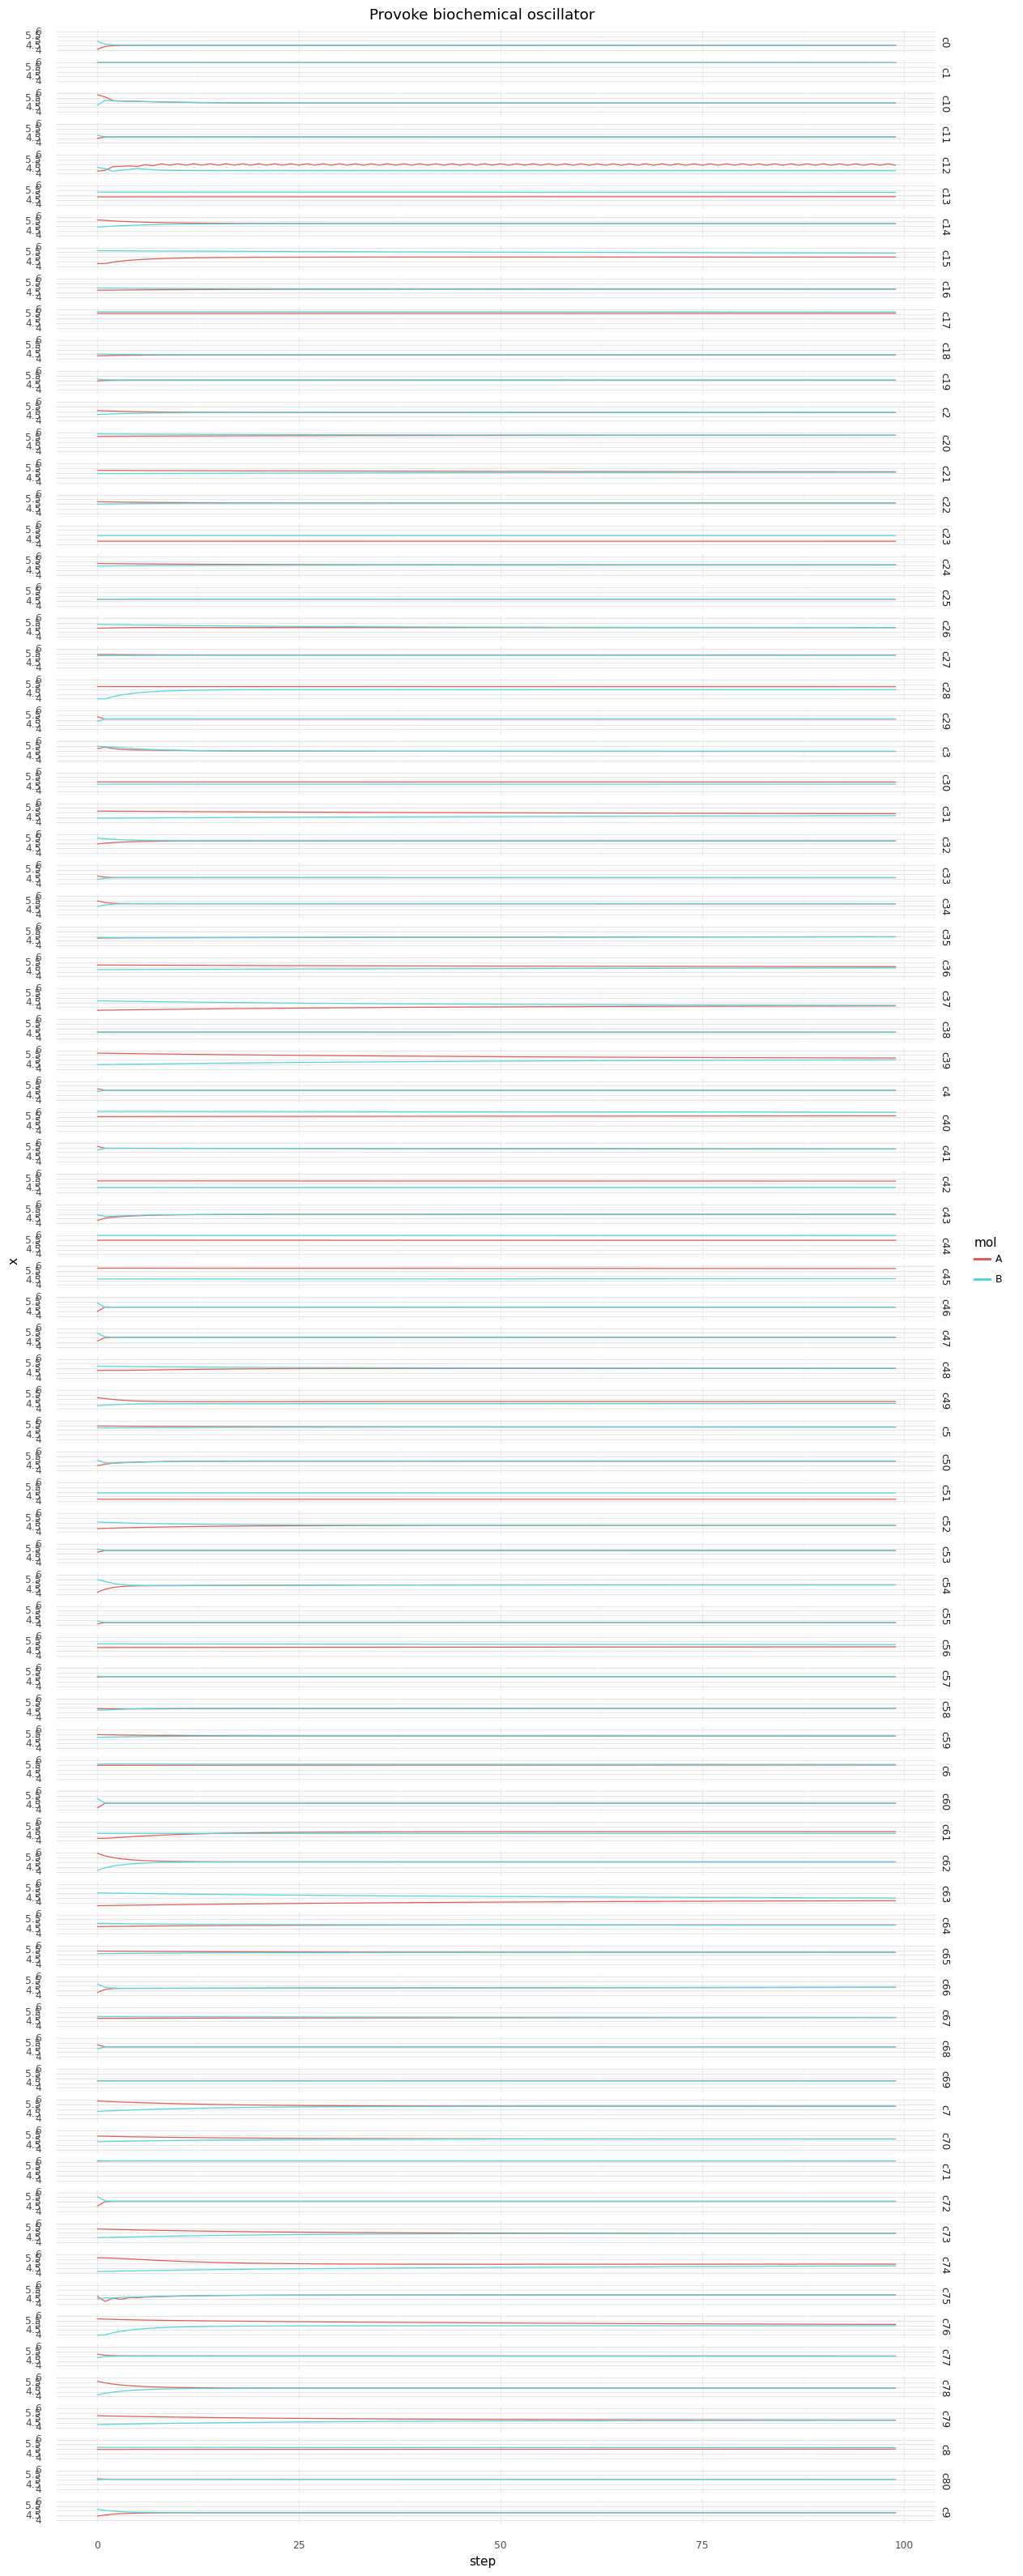

<ggplot: (8736654003729)>

In [2]:
steps = 100
size = 9

ms.Molecule._instances = {}  # rm previous instances
_A = ms.Molecule("A", 10e3)
_B = ms.Molecule("B", 10e3)
molecules = [_A, _B]
reactions = [([_A], [_B])]

chemistry = ms.Chemistry(molecules, reactions=reactions)
world = ms.World(chemistry=chemistry, map_size=9)

genomes = []
for _ in range(size * size):
    p0 = ms.ProteinFact(domain_facts=[ms.CatalyticDomainFact(([_A], [_B])), ms.RegulatoryDomainFact(_B, False, True), ms.RegulatoryDomainFact(_B, False, True)])
    p1 = ms.ProteinFact(domain_facts=[ms.CatalyticDomainFact(([_A], [_B])), ms.RegulatoryDomainFact(_A, False, True), ms.RegulatoryDomainFact(_A, False, True)])
    genomes.append(world.generate_genome(proteome=[p0, p1], size=138))
world.spawn_cells(genomes=genomes)

records = []
for step in range(steps):
    for ci in range(world.n_cells):
        label = f"c{ci}"
        for mi, mol in enumerate(world.chemistry.molecules):
            records.append({"step": step, "label": label, "mol": mol.name, "x": world.cell_molecules[ci, mi].item()})
    world.enzymatic_activity()
    world.diffuse_molecules()
    world.degrade_molecules()
df = pd.DataFrame.from_records(records)

(ggplot(df)
    + geom_line(aes(x="step", y="x", color="mol"))
    + facet_grid("label ~ .")
    + theme(figure_size=(14, 40))
    + ggtitle("Provoke biochemical oscillator"))

In [9]:
ci = 0
cell = world.get_cell(by_idx=ci)
for prot in cell.get_proteome(world=world):
    print(str(prot))
    for dom in prot.domains:
        print("-", repr(dom))

1 A <-> 1 B | B[i] inhibitor | B[i] inhibitor
- CatalyticDomain(A<->B,Km=3.09e+00,Vmax=2.44e-01)
- ReceptorDomain(B,Km=6.32e-01,cytosolic,inhibiting)
- ReceptorDomain(B,Km=4.32e+00,cytosolic,inhibiting)
1 A <-> 1 B | A[i] inhibitor | A[i] inhibitor
- CatalyticDomain(A<->B,Km=5.00e+00,Vmax=4.47e+01)
- ReceptorDomain(A,Km=1.54e+00,cytosolic,inhibiting)
- ReceptorDomain(A,Km=3.53e-01,cytosolic,inhibiting)
1 B <-> 1 A | A[i] inhibitor
- CatalyticDomain(B<->A,Km=1.59e-02,Vmax=4.40e+01)
- ReceptorDomain(A,Km=3.53e-01,cytosolic,inhibiting)


In [8]:
cell.genome[prot.cds_start:prot.cds_end]
cell

138

In [61]:
print("N\n", world.kinetics.N[ci])
print("Nf\n", world.kinetics.Nf[ci])
print("Nb\n", world.kinetics.Nb[ci])
print("Kmf\n", world.kinetics.Kmf[ci])
print("Kmb\n", world.kinetics.Kmb[ci])
print("Vmax\n", world.kinetics.Vmax[ci])
print("A\n", world.kinetics.A[ci])

N
 tensor([[ 2.,  2., -2.,  0.,  0.,  0.],
        [-2., -2.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])
Nf
 tensor([[0., 0., 2., 0., 0., 0.],
        [2., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
Nb
 tensor([[2., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
Kmf
 tensor([4.8209e-02, 2.0401e-01, 1.4013e-45, 1.4013e-45, 1.4013e-45, 1.4013e-45])
Kmb
 tensor([4.8209e-02, 2.0401e-01, 1.4013e-45, 1.4013e-45, 1.4013e-45, 1.4013e-45])
Vmax
 tensor([1.7043e-02, 5.6185e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])
A
 tensor([[-1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0

## Vmax and Km Distributions

To somewhat reflect reality I am sampling $K_M$ and $V_{max}$ from lognormal distributions.
Assumptions:

- $k_{cat}$ above zero up to 1e5 $s^{-1}$ (disregarding extremes like Catalase)
- $K_M$ is between 1e-5 M and 1e-1 M
- molecule map concentrations reflect mM, numbers usually range from 1 to 100
- $e_0$ of an enzyme is in $\mu M$

With that I would get a range for **Vmax from 0 to 100** in $\frac{mM}{s}$
and for **Km from 1e-2 to 100** in $mM$.

Both $V_{max}$ and $K_M$ can be aggregated in proteins.
Furthermore, for $K_M$ there is a forward and backward $K_M$.
The ratio between forward and backward is $K_e$.
The lower one is the one that was sampled.
The higher ones can go up to near inf (depending on the energy of the reaction).

In [46]:
ranges = [
    (1e-3, 100.0),
    (1e-2, 100.0),
]

records = []
for a, b in ranges:
    name = f"{a:.0e}-{b:.0e}"
    world = ms.World(chemistry=CHEMISTRY)
    world.kinetics = ms.Kinetics(
        molecules=CHEMISTRY.molecules,
        reactions=CHEMISTRY.reactions,
        vmax_range=(a, b)
    )
    genomes = [ms.random_genome(s=500) for _ in range(1000)]
    world.spawn_cells(genomes=genomes)
    vals = world.kinetics.Vmax[world.kinetics.Vmax > 0.0].flatten().tolist()
    records.extend([{"Vmax": d, "range": name} for d in vals])
    world.kill_cells(cell_idxs=list(range(world.n_cells)))
df = pd.DataFrame.from_records(records)
df.groupby("range").describe()

Vmax                                                       
              count       mean        std       min       25%       50%   
range                                                                     
1e-02-1e+02  8360.0  11.451036  18.090638  0.011833  0.385584  2.249320  \
1e-03-1e+02  8773.0   5.549919  12.496801  0.001036  0.018930  0.101061   

                                   
                   75%        max  
range                              
1e-02-1e+02  13.720966  86.031288  
1e-03-1e+02   2.915092  70.735970

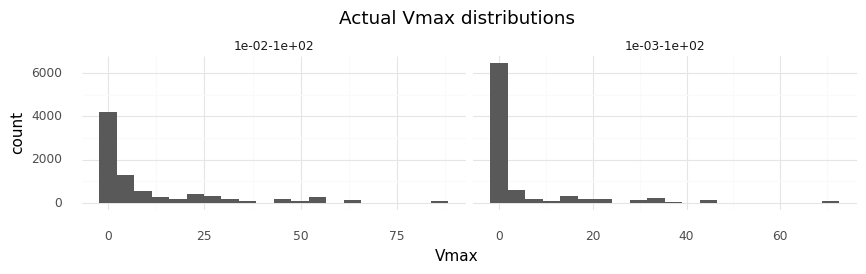

<ggplot: (8740120552938)>

In [47]:
(ggplot(df)
    + geom_histogram(aes(x="Vmax"), bins=20)
    + facet_grid(". ~ range", scales="free")
    + theme(figure_size=(10, 2))
    + ggtitle("Actual Vmax distributions"))

In [49]:
ranges = [
    (1e-2, 100.0),
    (1e-1, 10.0),
]

records = []
for a, b in ranges:
    name = f"{a:.0e}-{b:.0e}"
    world = ms.World(chemistry=CHEMISTRY)
    world.kinetics = ms.Kinetics(
        molecules=CHEMISTRY.molecules,
        reactions=CHEMISTRY.reactions,
        km_range=(a, b)
    )
    genomes = [ms.random_genome(s=500) for _ in range(1000)]
    world.spawn_cells(genomes=genomes)
    Km = torch.minimum(world.kinetics.Kmf, world.kinetics.Kmb)
    vals = Km[Km > 0.0].flatten().tolist()
    records.extend([{"Km": d, "range": name} for d in vals])
    world.kill_cells(cell_idxs=list(range(world.n_cells)))
df = pd.DataFrame.from_records(records)
df.groupby("range")["Km"].describe()

,count,mean,std,min,25%,50%,75%,max
range,,,,,,,,
1e-01-1e+01,20979.0,0.794087,1.57087,1.401298e-45,1.401298e-45,1.401298e-45,0.752473,7.927259
1e-02-1e+02,24800.0,3.629706,12.35755,1.401298e-45,1.401298e-45,1.401298e-45,0.103692,90.391632


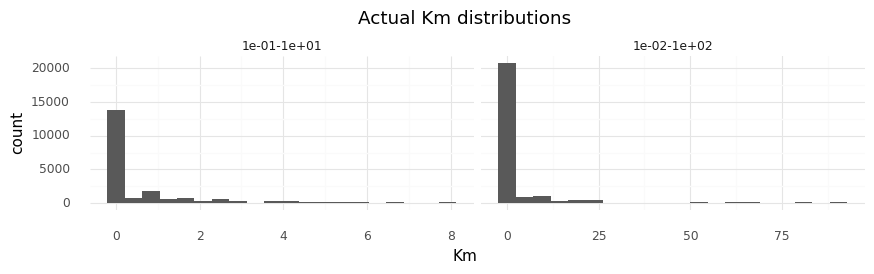

<ggplot: (8740130841153)>

In [50]:
(ggplot(df)
    + geom_histogram(aes(x="Km"), bins=20)
    + facet_grid(". ~ range", scales="free")
    + theme(figure_size=(10, 2))
    + ggtitle("Actual Km distributions"))

### Working Cell

Below I want to see how a cell actually starts to work and change its environment.
I currently don't have a clever way of defining a cell other than just assigning a genome.
So, the resulting cell is completely random.

First, a plot showing how the cell changes its environment over time.
Molecules suffixed with `[i]` are the intracellular molecule species, ones suffixed with `[e]` are the extracellular one
(on the pixel the cell lives on).

Second, networks depicting this cell's proteome.
To reduce the clutter I am plotting each protein one by one as a single network, instead of showing all proteins as a single network.
The protein itself is always the gray middle node with its size being proportional to $V_{Max}$.
Arrows point to and from substrates/products and effectors.
Substrates and product arrows are gray, inhibiting effectors are red, activating effectors are green.
Arrow widths are proportional to $K_M^{-1}$.
Intracellular molecules are blue, extracellular ones orange.

In [22]:
world = ms.World(chemistry=CHEMISTRY)
mol_2_idx = {d.name: i for i, d in enumerate(MOLECULES)}

while True:
    world.spawn_cells(genomes=[ms.random_genome(s=500)])
    cell = world.get_cell(by_idx=0)
    proteome = cell.get_proteome(world=world)
    if 10 <= len(proteome) <= 20:
        break
    world.kill_cells(cell_idxs=[0])

for pi, protein in enumerate(proteome):
    print(f"P{pi}:\t{protein.domains[0]}")
    for dom in protein.domains[1:]:
        print(f"    \t{dom}")

P0:	TransporterDomain(NADPH,Km=2.35e+01,Vmax=6.79e+01)
P1:	TransporterDomain(NADPH,Km=2.35e+01,Vmax=6.79e+01)
P2:	CatalyticDomain(NADP,methylen-FH4->NADPH,formyl-FH4,Km=4.34e+01,Vmax1.37e+00)
P3:	CatalyticDomain(NADP,methylen-FH4->NADPH,formyl-FH4,Km=4.34e+01,Vmax1.37e+00)
P4:	CatalyticDomain(NADP,methylen-FH4->NADPH,formyl-FH4,Km=4.34e+01,Vmax1.37e+00)
P5:	CatalyticDomain(NADPH,CO2->NADP,formiat,Km=1.77e+00,Vmax1.72e+00)
P6:	CatalyticDomain(NADPH,CO2->NADP,formiat,Km=1.77e+00,Vmax1.72e+00)
P7:	CatalyticDomain(NADPH,CO2->NADP,formiat,Km=1.77e+00,Vmax1.72e+00)
P8:	TransporterDomain(Ni-ACS,Km=1.25e+00,Vmax=2.77e+00)
    	TransporterDomain(methyl-Ni-ACS,Km=2.26e-02,Vmax=1.29e-01)
P9:	TransporterDomain(Ni-ACS,Km=1.25e+00,Vmax=2.77e+00)
    	TransporterDomain(methyl-Ni-ACS,Km=2.26e-02,Vmax=1.29e-01)
P10:	TransporterDomain(methyl-Ni-ACS,Km=2.26e-02,Vmax=1.29e-01)
P11:	TransporterDomain(methyl-Ni-ACS,Km=2.26e-02,Vmax=1.29e-01)
P12:	TransporterDomain(methyl-Ni-ACS,Km=2.26e-02,Vmax=1.29e-01)


In [23]:
records = []
for si in range(20):
    for idx, mol in enumerate(MOLECULES):
        records.append({
            "step": si,
            "molecule": mol.name,
            "location": "intracellular",
            "c": world.cell_molecules[0, idx].item()
        })
        records.append({
            "step": si,
            "molecule": mol.name,
            "location": "extracellular",
            "c": world.molecule_map[idx, cell.position[0], cell.position[1]].item()
        })
    world.molecule_map[mol_2_idx["ATP"]] += 5.0
    world.molecule_map[mol_2_idx["NADPH"]] += 5.0
    world.molecule_map[mol_2_idx["CO2"]] += 5.0
    mask = world.cell_molecules[:, mol_2_idx["acetyl-CoA"]] > 5.0
    world.cell_molecules[mask, mol_2_idx["acetyl-CoA"]] -= 4.9
    world.cell_molecules[mask, mol_2_idx["HS-CoA"]] += 4.9
    world.enzymatic_activity()
    world.degrade_molecules()
    world.diffuse_molecules()
df = pd.DataFrame.from_records(records)

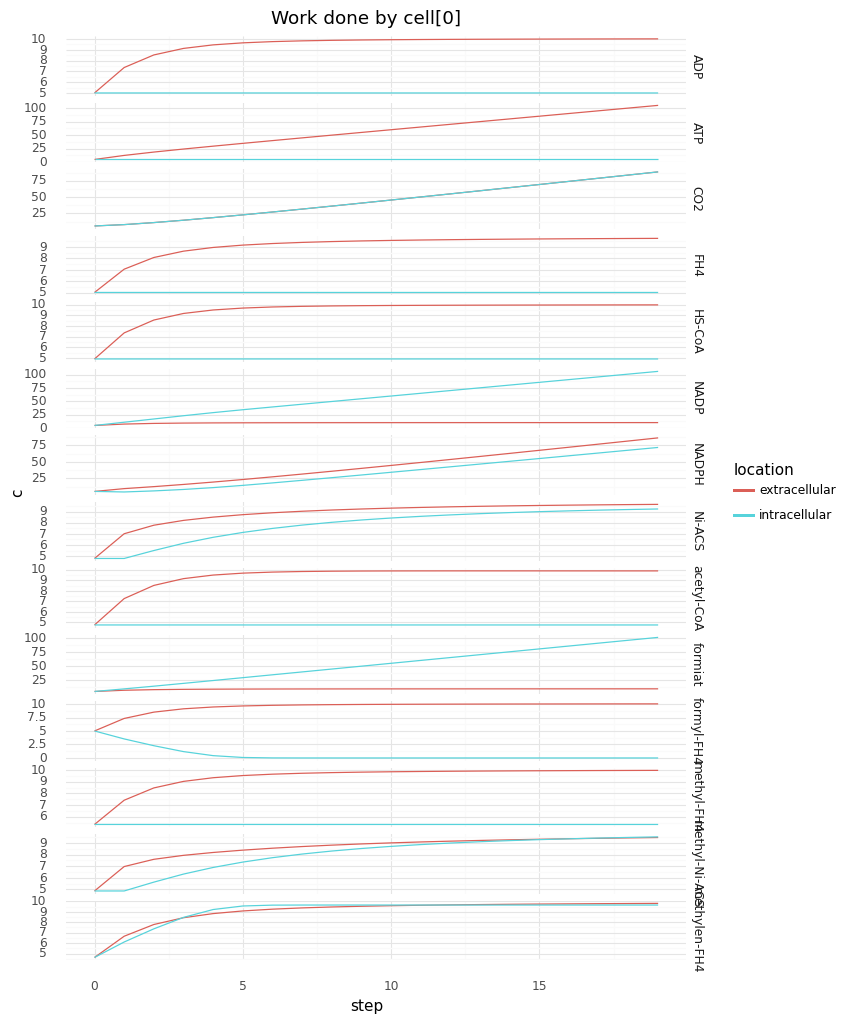

<ggplot: (8740131941106)>

In [24]:
(ggplot(df)
    + geom_line(aes(x="step", y="c", color="location"))
    + facet_grid("molecule ~ .", scales="free")
    + theme(figure_size=(8, 12))
    + ggtitle(f"Work done by cell[{cell.idx}]"))

In [25]:
graphs = []
for pi, protein in enumerate(proteome):
    vs = []
    G = nx.DiGraph()
    for dom in protein.domains:
        kwargs = {
            "w": abs(1 / math.log(1 + dom.km)),
            "c": "gray"
        }
        if isinstance(dom, ms.CatalyticDomain):
            vs.append(dom.vmax)
            for mol in dom.substrates:
                G.add_edge(f"{mol.name}[i]", "", **kwargs)
            for mol in dom.products:
                G.add_edge("", f"{mol.name}[i]", **kwargs)
        if isinstance(dom, ms.TransporterDomain):
            vs.append(dom.vmax)
            G.add_edge(f"{dom.molecule.name}[i]", "", **kwargs)
            G.add_edge("", f"{dom.molecule.name}[e]", **kwargs)
        if isinstance(dom, ms.RegulatoryDomain):
            kwargs["c"] = "r" if dom.is_inhibiting else "g"
            suffix = "[e]" if dom.is_transmembrane else "[i]"
            G.add_edge(f"{mol.name}{suffix}", "", **kwargs)
    
    for key, val in G.nodes.items():
        if key == "":
            val["s"] = sum(vs) / len(vs) if len(vs) > 0 else 1e-2
            val["c"] = "gray"
        else:
            val["s"] = 1e-1
            val["c"] = "orange" if key.endswith("[e]") else "blue"
        val["s"] = math.log(1 + val["s"])

    graphs.append(G)

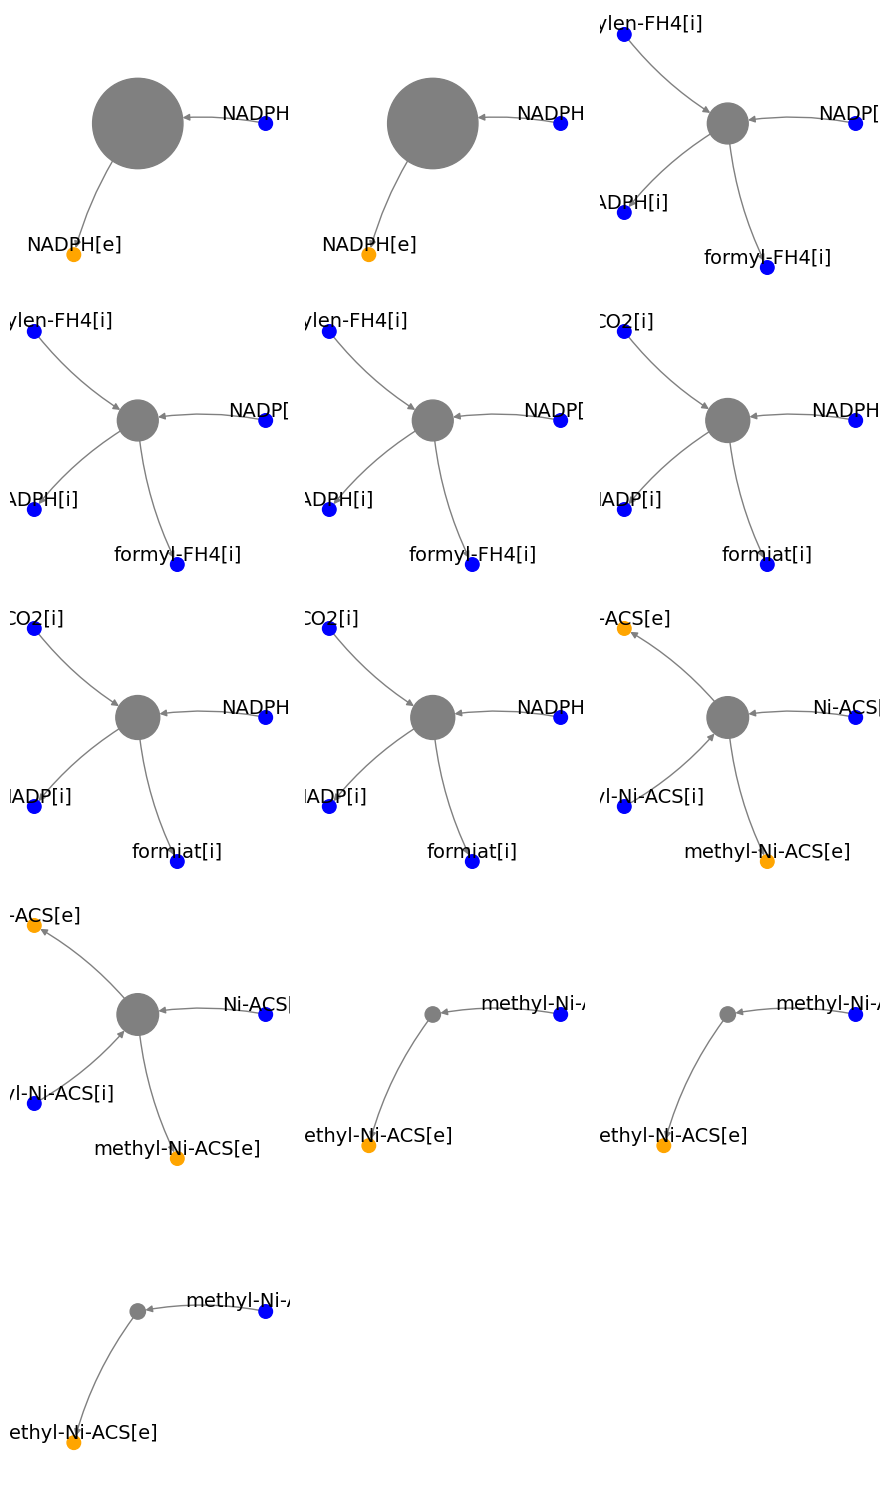

In [26]:
n_cols = 3
n_rows = int(math.ceil(len(graphs) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(n_cols * 3, n_rows * 3))

for plot_i, ax in enumerate(axs.flat):
    ax.axis("off")
    
    if plot_i < len(graphs):
        G = graphs[plot_i]
    
        pos = nx.circular_layout(G, center=(0, 0))
        pos[""] = (0, 0)
        
        edgewidths = [G.get_edge_data(u, v)["w"] * 1e-4 + 1 for u, v in G.edges()]
        nodesizes = [v["s"] * 1e3 for v in G.nodes.values()]
        edgecols = [G.get_edge_data(u, v)["c"] for u, v in G.edges()]
        nodecols = [v["c"] for v in G.nodes.values()]

        nx.draw(
            G, pos, ax=ax,
            node_size=nodesizes,
            node_color=nodecols,
            width=edgewidths,
            edge_color=edgecols,
            connectionstyle="arc3,rad=0.1",
            
        )

        nx.draw_networkx_labels(G, pos, ax=ax, font_size=14, verticalalignment="bottom")
        ax.margins(0.1, 0.05)

fig.tight_layout()
plt.show()

## Free Energy in Simulation

Here, I basically want to check that cells can't just create energy out of nothing.
Cells can make use of the internal energy of molecules and concentration differences of molecules to drive reactions.
While doing that, and while molecules are allowed to diffuse, the overall available free Gibb's energy of the world decreases.
So, without regular energy supply cells will eventually all die and molecules will be spread equally over the map.

The change of internal energy of all molecules combined is called $\Delta U$ here.
Unfortunately, I don't know how to properly calculate the (physical property) entropy.
Thus for entropy change $\Delta S$ the Shannon entropy change is used over all molecule concentrations.
As far is I know I cannot compare this type of entropy to any physical energy.
Here, it just functions as a way of seeing how ordered or disordered molecules are.

Simulations are run with only diffusion, only enzymatic activity, and both diffusion and enzymatic activity.
Diffusion only should be $\Delta U = 0$ and some $\Delta S$.
Enzymatic activity only should create some $\Delta U$ but it should be limited by reaction equilibriums.
Without diffusion cells can't get rid of accumulated products, or gather new substrates.
With both diffusion and enzymatic activity there should be constant movement in both until all molecules were converted to the lowest energy molecules species.

> Note that diffusion-only also creates a small $\Delta U$.
> This is because the convolution function that performs the diffusion is not precise.
> Everything is currently calculated using floats (32 bits).
> Every calculation has errors many digits behind the comma.
> However, with one thousand of repetitions and a map size of ~16k these errors add up.

In [33]:
def init_world() -> ms.World:
    world = ms.World(chemistry=CHEMISTRY)
    world.spawn_cells(genomes=[ms.random_genome(s=300) for _ in range(1000)])
    return world

def world_energy(world: ms.World) -> float:
    energies = torch.tensor([d.energy for d in world.chemistry.molecules])
    e_map = torch.einsum("mxy,m->xy", world.molecule_map, energies)
    e_cells = torch.einsum("cm,m->c", world.cell_molecules, energies)
    return (e_map.sum() + e_cells.sum()).item()

def world_entropy(world: ms.World) -> float:
    t = torch.cat([world.molecule_map.flatten(), world.cell_molecules.flatten()])
    probs = (t - t.min()) / (t.max() - t.min())
    return torch.distributions.Categorical(probs.flatten()).entropy().item()

records = []
n_steps = 1000

world = init_world()
U0 = world_energy(world)
S0 = world_entropy(world)
for step_i in range(n_steps):
    world.diffuse_molecules()
    records.append({
        "label": "diffusion",
        "step": step_i,
        "dU": U0 - world_energy(world),
        "dS": S0 - world_entropy(world),
    })

world = init_world()
U0 = world_energy(world)
S0 = world_entropy(world)
for step_i in range(n_steps):
    world.enzymatic_activity()
    records.append({
        "label": "enzymatic-activity",
        "step": step_i,
        "dU": U0 - world_energy(world),
        "dS": S0 - world_entropy(world)
    })

world = init_world()
U0 = world_energy(world)
S0 = world_entropy(world)
for step_i in range(n_steps):
    world.enzymatic_activity()
    world.diffuse_molecules()
    records.append({
        "label": "both",
        "step": step_i,
        "dU": U0 - world_energy(world),
        "dS": S0 - world_entropy(world)
    })

df = pd.DataFrame.from_records(records)
df = df.melt(id_vars=["step", "label"], value_vars=["dU", "dS"])
df["variable"] = pd.Categorical(df["variable"], categories=["dU", "dS"])
df["label"] = pd.Categorical(df["label"], categories=["diffusion", "enzymatic-activity", "both"])

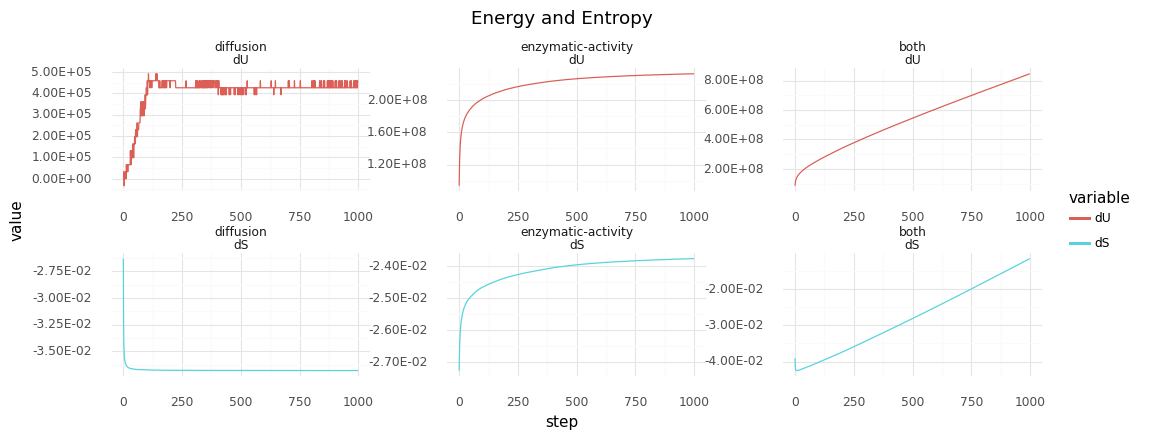

<ggplot: (8769921315889)>

In [34]:
(ggplot(df)
    + geom_line(aes(x="step", y="value", color="variable"))
    + scale_y_continuous(labels=lambda d: [f"{dd:.2E}" for dd in d])
    + facet_wrap("~ label + variable", scales="free", dir="v", nrow=2)
    + theme(legend_position=None, figure_size=(12, 4), subplots_adjust={"wspace": 0.3, "hspace": 0.5})
    + ggtitle("Energy and Entropy"))

## Survival and Replication Rate

Adding evolutionary pressure will be done by selectively killing or replicating cells.
For a single cell this is basically a step function; _e.g._ either it dies or not.
But for the entirety of cells this can be smooth curve when slowly changing the probability of dying or replicating based on an input.
Here, I am thinking about some molecule species $X$ which can have different concentrations in the cell.
Depending on the concentration $[X]$ a cell has a certain probability of dying or replicating.

First, I am just visualizing some functions that could be used to derive probabilities from $[X]$.
For the expected value range of $[X]$ I want to have a steady increase or decrease in probability.
Over multiple rounds these probabilities accumulate.
Two specific functions for killing and replicating a cell were chosen.
Then, the likelihood of a cell dying (only needs to occur once) or replicating at least once are shown over the course of many time steps.
Finally, these likelihoods interact: a cell that died can't replicate anymore; a cell that replicated increased the overall number of cells.
Cell growth is simulated with these replication and killing functions.
There could be multiple conditions to kill or replicate a cell.
Having multiple kill or replication conditions will skew cell growth downwards or upwards.
But the effect is much smaller than the effect of decreasing or increasing $[X]$ by 1.

In [29]:
def increasing(t: torch.Tensor, k: float, n: int) -> torch.Tensor:
    return t ** n / (t ** n + k ** n)

def decreasing(t: torch.Tensor, k: float, n: int) -> torch.Tensor:
    return k ** n / (t ** n + k ** n)

X = torch.arange(0, 10, .01)

dfs = []
for k in (0.5, 1, 5, 10):
    for n in (1, 3, 5, 7):
        df = pd.DataFrame({
            "[X]": X.tolist() + X.tolist(),
            "y": increasing(X, k, n).tolist() + decreasing(X, k, n).tolist(),
            "d": ["increasing"] * len(X) + ["decreasing"] * len(X),
            "k": 2 * [k] * len(X),
            "n": 2 * [n] * len(X)
        })
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

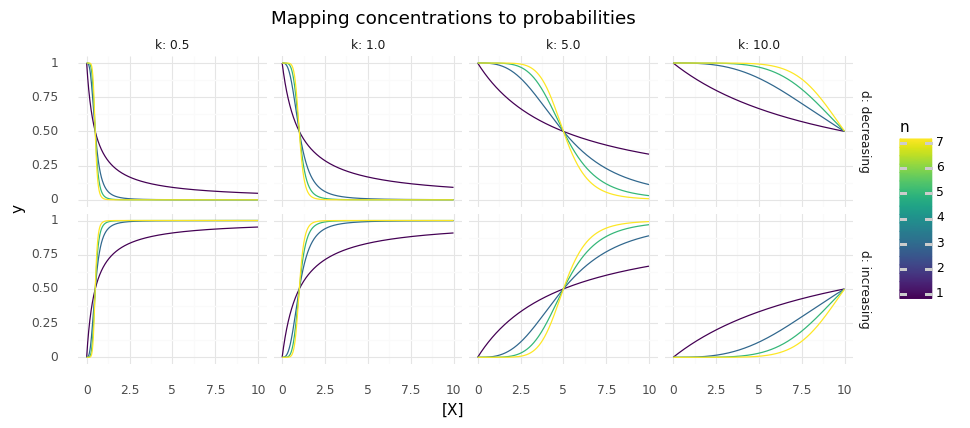

<ggplot: (8740123437053)>

In [30]:
(ggplot(df, aes(y="y", x="[X]"))
    + geom_line(aes(color="n", group="n"))
    + facet_grid("d ~ k", scales="free", labeller="label_both")
    + theme(figure_size=(10, 4))
    + ggtitle("Mapping concentrations to probabilities"))

In [31]:
def replicate(t: torch.Tensor, k=15, n=5) -> torch.Tensor:
    return t ** n / (t ** n + k ** n)

def kill(t: torch.Tensor, k=1, n=7) -> torch.Tensor:
    return k ** n / (t ** n + k ** n)

actions = {"replicated": replicate, "killed": kill}
n_mols = [1.0, 2.0, 3.0, 4.0, 5.0]
n_steps = 1000

records = []
for n_mol in n_mols:
    for action, fun in actions.items():
        for step in range(n_steps):
            records.append({
                "step": step,
                "[X]": n_mol,
                "p(action)": (1 - (1 - fun(n_mol)) ** step),
                "action": action,
            })

df = pd.DataFrame.from_records(records)

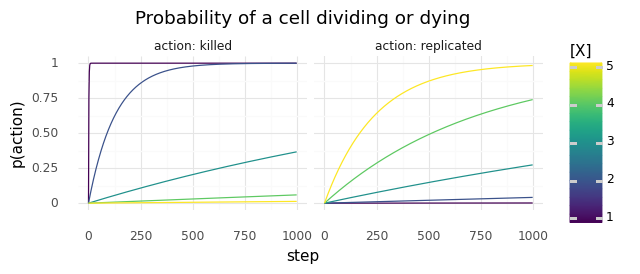

<ggplot: (8740131052541)>

In [32]:
(ggplot(df, aes(y="p(action)", x="step"))
    + geom_line(aes(color="[X]", group="[X]"))
    + facet_grid(". ~ action", labeller="label_both")
    + theme(figure_size=(6, 2))
    + ggtitle("Probability of a cell dividing or dying"))

In [33]:
def sample(p: torch.Tensor) -> list[int]:
    idxs = torch.argwhere(torch.bernoulli(p))
    return idxs.flatten().tolist()

n_cells = 1000
n_steps = 100
n_mols = [1, 2, 3, 4, 5]

records = []
for n_mol in n_mols:
    X = torch.ones(n_cells) * n_mol
    for step in range(n_steps):
        
        kidxs = sample(kill(X))
        keep = torch.ones(X.size(), dtype=bool)
        keep[kidxs] = False
        X = X[keep]

        ridxs = sample(replicate(X))
        X = torch.cat([X, torch.ones(len(ridxs)) * n_mol])
        
        records.append({
            "step": step,
            "[X]": n_mol,
            "cells": len(X),
        })

        if len(X) > 1e6:
            break

df = pd.DataFrame.from_records(records)

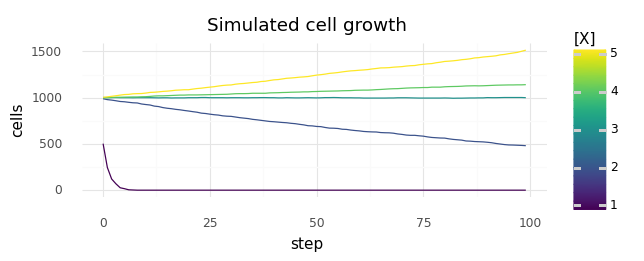

<ggplot: (8740131059899)>

In [34]:
(ggplot(df, aes(y="cells", x="step"))
    + geom_line(aes(color="[X]", group="[X]"))
    + theme(figure_size=(6, 2))
    + ggtitle("Simulated cell growth"))

In [35]:
n_cells = 1000
n_steps = 100
n_mol = 3.07 # to get 1k-1r in equilibrium
setups = [(1, 1), (1, 2), (1, 4), (2, 1), (4, 1)]

records = []
for n_kills, n_replications in setups:
    X = torch.ones(n_cells) * n_mol
    label = f"{n_kills}k-{n_replications}r"
    for step in range(n_steps):
        
        for _ in range(n_kills):
            kidxs = sample(kill(X))
            keep = torch.ones(X.size(), dtype=bool)
            keep[kidxs] = False
            X = X[keep]

        for _ in range(n_replications):
            ridxs = sample(replicate(X))
            X = torch.cat([X, torch.ones(len(ridxs)) * n_mol])
        
        records.append({
            "step": step,
            "cells": len(X),
            "conditions": label,
        })

        if len(X) > 1e6:
            break

df = pd.DataFrame.from_records(records)

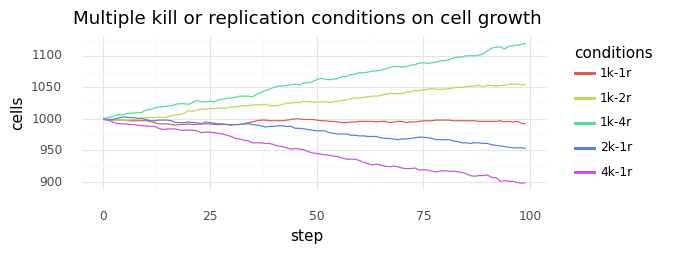

<ggplot: (8740131940719)>

In [36]:
(ggplot(df, aes(y="cells", x="step"))
    + geom_line(aes(color="conditions"))
    + theme(figure_size=(6, 2))
    + ggtitle("Multiple kill or replication conditions on cell growth"))

In [37]:
n_cells = 1000
n_steps = 1000
thresh = 7000
split_ratios = [0.1, 0.2, 0.3]
n_mols = [3, 4, 5, 6]

def random_split(t: torch.Tensor, r: float) -> list[int]:
    n = len(t)
    return t[torch.randint(n, size=(int(r * n), ))]

records = []
for split_ratio in split_ratios:
    X = torch.cat([torch.ones(int(n_cells / len(n_mols))) * d for d in n_mols])
    
    kwargs = {"step": 0, "split": split_ratio}
    for n_mol in n_mols:
        records.append({**kwargs, "[X]": n_mol, "cells": len(X[X == n_mol])})

    for step in range(n_steps):
        kwargs = {"step": step, "split": split_ratio}
        if len(X) > thresh:
            for n_mol in n_mols:
                records.append({**kwargs, "[X]": n_mol, "cells": len(X[X == n_mol])})
            X = random_split(X, split_ratio)

        records.append({**kwargs, "[X]": -1, "cells": len(X)})
        
        kidxs = sample(kill(X))
        keep = torch.ones(X.size(), dtype=bool)
        keep[kidxs] = False
        X = X[keep]

        ridxs = sample(replicate(X))
        X = torch.cat([X, X[ridxs].clone()])

df = pd.DataFrame.from_records(records)

One way of keeping cells in exponential growth can be to split them.
However, that introduces artifacts. Fast growing cells will be oversampled.
Slow growing proteomes are quickly lost.

Below I want to visualize this on a concrete case.
The replication and kill rates from above are simulated with different types of cells.
All of these cells grow and increase in number, as they all have $[X] > 3$.
However, some of these cells grow faster as they have higher $[X]$.
When cells grow over a total of 7000 (roughly half the 128x128 map is covered)
they are split with a certain split ratio.
Then they continue growing.

First, a random split is shown. Fast growing cells are more abundant.
So, they have a higher chance of being picked.
A higher pick ratio increase the chance of slow growing cells to be picked.
So, stochastic effects are a bit reduced.
But splits with higher ratio have to happen more often and the tendency to loose these slow growing cells persists.

Second, cells can be selectively split.
_E.g._ one could pick the same amount of cells for each type of cells.
However, then over many splits fast growing cells would not benefit from being fast growers.
So, no real selection process happens.
One could also find a balance between these 2 ways of splitting.
Fast growing cells should have a benefit from being faster growers, but slow growing cells should have a chance of surviving the split.

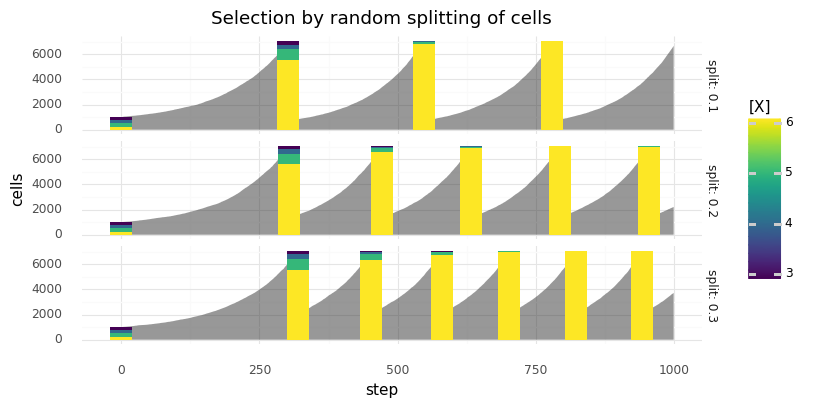

<ggplot: (8740123381520)>

In [38]:
(ggplot(df, aes(x="step", y="cells"))
    + geom_area(data=df[df["[X]"] == -1], alpha=.5)
    + geom_col(aes(fill="[X]", group="[X]"), data=df[df["[X]"] != -1], width=40)
    + facet_grid("split ~ .", labeller="label_both")
    + theme(figure_size=(8, 4))
    + ggtitle("Selection by random splitting of cells"))

In [39]:
n_cells = 1000
n_steps = 1000
thresh = 7000
split_ratio = 0.2
n_mols = [3, 4, 5, 6]
biases = [.1, .5, .9]

def biased_split(t: torch.Tensor, b: float) -> list[int]:
    m = len(t) / len(t.unique())
    counts = {d.item(): len(t[t == d]) for d in t.unique()}
    samples = {k: (d * (1 - b) + m * b) * split_ratio for k, d in counts.items()}
    new_cells = [[k] * int(d) for k, d in samples.items()]
    return torch.tensor([dd for d in new_cells for dd in d])

records = []
for bias in biases:
    X = torch.cat([torch.ones(int(n_cells / len(n_mols))) * d for d in n_mols])

    kwargs = {"step": 0, "bias": bias}
    for n_mol in n_mols:
        records.append({**kwargs, "[X]": n_mol, "cells": len(X[X == n_mol])})

    for step in range(n_steps):
        kwargs = {"step": step, "bias": bias}
        if len(X) > thresh:
            for n_mol in n_mols:
                records.append({**kwargs, "[X]": n_mol, "cells": len(X[X == n_mol])})
            X = biased_split(X, bias)

        records.append({**kwargs, "[X]": -1, "cells": len(X)})
        
        kidxs = sample(kill(X))
        keep = torch.ones(X.size(), dtype=bool)
        keep[kidxs] = False
        X = X[keep]

        ridxs = sample(replicate(X))
        X = torch.cat([X, X[ridxs].clone()])

df = pd.DataFrame.from_records(records)
df["bias"] = pd.Categorical(df["bias"], categories=biases)

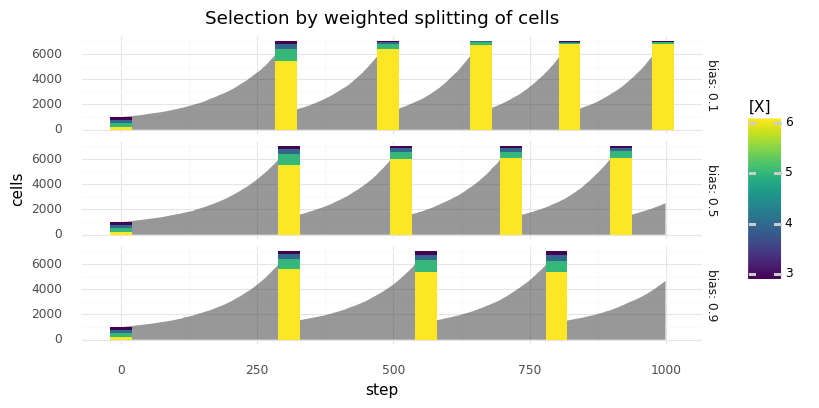

<ggplot: (8740130764254)>

In [40]:
(ggplot(df, aes(x="step", y="cells"))
    + geom_area(data=df[df["[X]"] == -1], alpha=.5)
    + geom_col(aes(fill="[X]", group="[X]"), data=df[df["[X]"] != -1], width=40)
    + facet_grid("bias ~ .", labeller="label_both")
    + theme(figure_size=(8, 4))
    + ggtitle("Selection by weighted splitting of cells"))

## Other Plots

Some other plots I could use for the documentation.

In [41]:
def mm(t: torch.Tensor, v: float, k: float, n: int) -> torch.Tensor:
    return t ** n / (k + t) ** n * v

X = torch.arange(0, 10, 0.1)

dfs = []
for n in [1, 3, 5]:
    Y = mm(X, 1.0, 1.0, n)
    dfs.append(pd.DataFrame({
        "x": X.tolist(),
        "y": Y.tolist(),
        "value": f"n={n}",
        "varying": "n"
    }))
for k in [1.0, 2.5, 5.0]:
    Y = mm(X, 1.0, k, 1)
    dfs.append(pd.DataFrame({
        "x": X.tolist(),
        "y": Y.tolist(),
        "value": f"Km={k}",
        "varying": "Km"
    }))
for v in [0.8, 1.0, 1.2]:
    Y = mm(X, v, 1.0, 1)
    dfs.append(pd.DataFrame({
        "x": X.tolist(),
        "y": Y.tolist(),
        "value": f"Vmax={v}",
        "varying": "Vmax"
    }))
df = pd.concat(dfs, ignore_index=True)

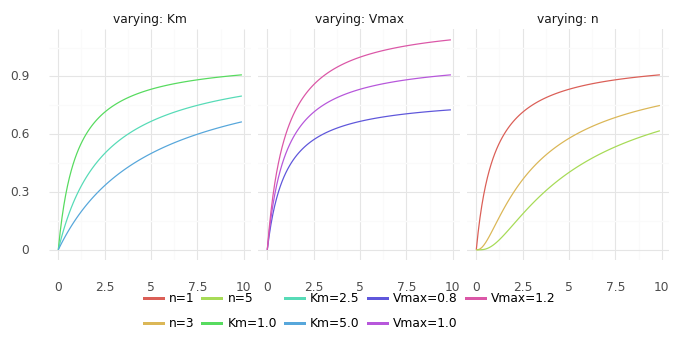

<ggplot: (8740123401361)>

In [42]:
(ggplot(df, aes(x="x", y="y"))
    + geom_line(aes(color="value"), data=df[df["varying"] == "n"])
    + geom_line(aes(color="value"), data=df[df["varying"] == "Km"])
    + geom_line(aes(color="value"), data=df[df["varying"] == "Vmax"])
    + facet_grid(". ~ varying", labeller="label_both")
    + theme(figure_size=(8, 3), legend_position="bottom", legend_title=element_blank(), axis_title=element_blank()))

In [43]:
world = ms.World(chemistry=CHEMISTRY)
mol_2_idx = {d.name: i for i, d in enumerate(MOLECULES)}
world.molecule_map[mol_2_idx["ATP"]] += 10.0
world.molecule_map[mol_2_idx["NADPH"]] += 10.0
world.molecule_map[mol_2_idx["CO2"]] += 10.0
world.spawn_cells(genomes=[ms.random_genome(s=4000)])
cell = world.get_cell(by_idx=0)

records = []
for si in range(100):
    for idx, mol in enumerate(MOLECULES):
        records.append({
            "step": si,
            "molecule": mol.name,
            "location": "intracellular",
            "c": world.cell_molecules[0, idx].item()
        })
        records.append({
            "step": si,
            "molecule": mol.name,
            "location": "extracellular",
            "c": world.molecule_map[idx, cell.position[0], cell.position[1]].item()
        })
    world.molecule_map[mol_2_idx["ATP"]] += 2.0
    world.molecule_map[mol_2_idx["NADPH"]] += 2.0
    world.molecule_map[mol_2_idx["CO2"]] += 2.0
    mask = world.cell_molecules[:, mol_2_idx["acetyl-CoA"]] > 5.0
    world.cell_molecules[mask, mol_2_idx["acetyl-CoA"]] -= 4.9
    world.cell_molecules[mask, mol_2_idx["HS-CoA"]] += 4.9
    world.enzymatic_activity()
    world.degrade_molecules()
    world.diffuse_molecules()
df = pd.DataFrame.from_records(records)

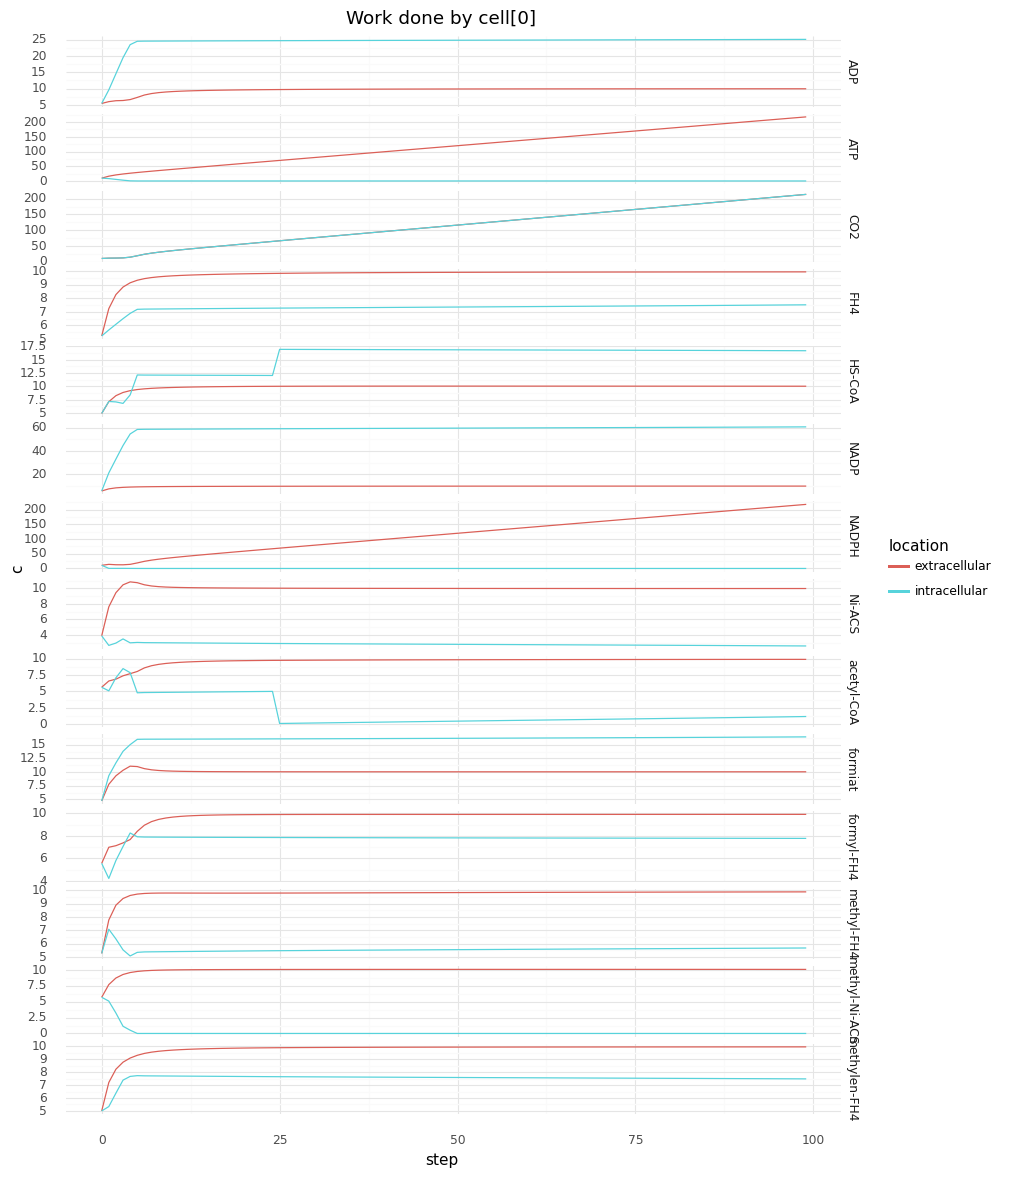

<ggplot: (8740130713099)>

In [44]:
(ggplot(df)
    + geom_line(aes(x="step", y="c", color="location"))
    + facet_grid("molecule ~ .", scales="free")
    + theme(figure_size=(10, 14))
    + ggtitle(f"Work done by cell[{cell.idx}]"))

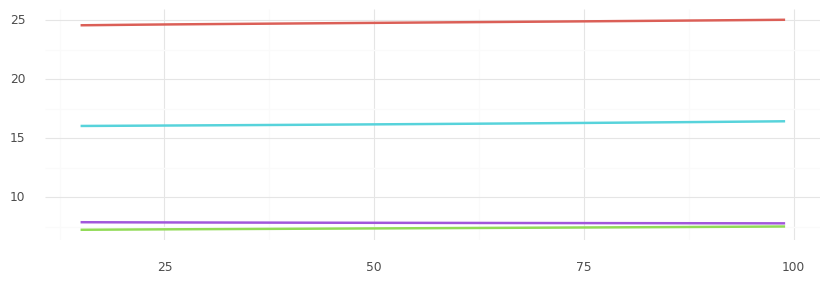

<ggplot: (8740123428036)>

In [45]:
molmask = df["molecule"].isin(["ADP", "FH4", "formiat", "formyl-FH4"])
locmask = df["location"] == "intracellular"
stepmask = df["step"] >= 15

(ggplot(df[molmask & locmask & stepmask])
    + geom_smooth(aes(x="step", y="c", color="molecule"), se=False, span=0.1)
    + theme(figure_size=(10, 3), legend_position="none", axis_title=element_blank()))

In [26]:
ms.Molecule._instances = {}  # rm previous instances
_ma = ms.Molecule("A", 10e3)
_mb = ms.Molecule("B", 20e3)
_mc = ms.Molecule("C", 30e3)
_md = ms.Molecule("D", 10e3)
chem = ms.Chemistry(
    molecules=[_ma, _mb, _mc, _md],
    reactions=[([_ma], [_mb]), ([_mc], [_md])]
)

In [105]:
n_steps = 50
examples = [
    ("A <-> B | +10kJ", [([_ma], [_mb])]),
    ("A + C <-> B + D | -10kJ", [([_ma], [_mb]), ([_mc], [_md])]),
]

records = []
for label, reactions in examples:
    world = ms.World(chemistry=chem, mol_map_init="zeros")
    protein = ms.ProteinFact(domain_facts=[ms.CatalyticDomainFact(d) for d in reactions])

    genomes = []
    while len(genomes) < 1:
        genome = world.generate_genome(proteome=[protein], size=50)
        proteomes = world.genetics.translate_genomes(genomes=[genome])
        if len(proteomes) == 1 and len(proteomes[0]) == 1:
            genomes.append(genome)

    world.spawn_cells(genomes=genomes)
    world.cell_molecules = torch.rand_like(world.cell_molecules) + 10.0

    for step_i in range(n_steps):
        x, y = world.cell_positions[0].tolist()
        for mi, mol in enumerate(chem.molecules):
            records.append({
                "label": label,
                "t[s]": step_i,
                "molecule": mol.name,
                "[X]": world.cell_molecules[0][mi].item()
            })

        world.enzymatic_activity()
        world.diffuse_molecules()

df = pd.DataFrame.from_records(records)
df["label"] = pd.Categorical(df["label"], categories=[d[0] for d in examples])

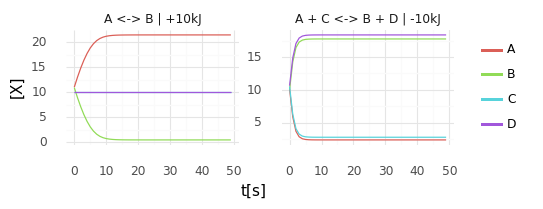

<ggplot: (8766748848174)>

In [106]:
(ggplot(df)
    + geom_line(aes(x="t[s]", y="[X]", color="molecule"))
    + facet_wrap("~ label", scales="free")
    + theme(figure_size=(5, 1.5), subplots_adjust={'wspace': 0.25})
    + theme(legend_position="right", legend_title=element_blank()))